## Question 3: TARNet

        
For this question, I referenced a few sites/ papers/ github repositories, especially:

- https://github.com/oddrose/cfrnet
- https://github.com/anthem-ai/causalforge?tab=readme-ov-file#testing

I spent 3 hours

In [ ]:
import numpy as np
import tqdm
trainset = np.load('ihdp_npci_1-100.train.npz')
testset = np.load('ihdp_npci_1-100.test.npz')

In [2]:
X_tr = trainset['x'][:, :, 0]
T_tr = trainset['t'][:, 0:1]
YF_tr = trainset['yf'][:, 0:1]
YCF_tr = trainset['ycf'][:, 0:1]
mu_0_tr = trainset['mu0'][:, 0:1]
mu_1_tr = trainset['mu1'][:, 0:1]

X_te = testset['x'][:, :, 0]
T_te = testset['t'][:, 0:1]
YF_te = testset['yf'][:, 0:1]
YCF_te = testset['ycf'][:, 0:1]
mu_0_te = testset['mu0'][:, 0:1]
mu_1_te = testset['mu1'][:, 0:1]

print(X_tr.shape, T_tr.shape, YF_tr.shape, YCF_tr.shape, mu_0_tr.shape , mu_1_tr.shape)
print(X_te.shape, T_te.shape, YF_te.shape, YCF_te.shape, mu_0_te.shape , mu_1_te.shape)

(672, 25) (672, 1) (672, 1) (672, 1) (672, 1) (672, 1)
(75, 25) (75, 1) (75, 1) (75, 1) (75, 1) (75, 1)


In [3]:
u = T_tr.mean()
w_tr = T_tr/(2*u) + (1 - T_tr)/(2*(1-u))

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader


class BalancedTreatmentDataset(Dataset):
    def __init__(self, X, T, YF, w):
        self.X = torch.Tensor(X)
        self.T = torch.Tensor(T)
        self.YF = torch.Tensor(YF)
        self.w = torch.Tensor(w)
        
        self.treated_idx = np.where(T == 1)[0]
        self.control_idx = np.where(T == 0)[0]
        
        self.samples_per_group = min(len(self.treated_idx), len(self.control_idx))
    
    def __len__(self):
        return self.samples_per_group * 2  # Total samples (treated + control)
    
    def __getitem__(self, idx):
        if idx < self.samples_per_group:
            sample_idx = self.treated_idx[idx]
        else:
            sample_idx = self.control_idx[idx - self.samples_per_group]
            
        return self.X[sample_idx], self.T[sample_idx], self.YF[sample_idx], self.w[sample_idx]

# Create dataset and dataloader
train_dataset = BalancedTreatmentDataset(X_tr, T_tr, YF_tr, w_tr)
batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,  
    shuffle=True
)

In [5]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 25
feature_dim = 32

rep_model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, feature_dim),
            nn.ReLU(),
)

control_model = nn.Sequential(
            nn.Linear(feature_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.ReLU(),
)

treatment_model = nn.Sequential(
            nn.Linear(feature_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.ReLU(),
)


class TARNet(nn.Module):
    def __init__(self, rep_model, control_model, treatment_model):
        super().__init__()
        self.rep_model = rep_model
        self.control_model = control_model
        self.treatment_model = treatment_model

    def forward(self, inputs):
        x, t = inputs

        representation = self.rep_model(x)

        control = self.control_model(representation)
        treatment = self.treatment_model(representation)

        concat = torch.cat([control, treatment], dim=1)
        batch_indices = torch.arange(len(t)).unsqueeze(1).to(device)
        indices = torch.cat([batch_indices, t], dim=1)
        selected_output = concat[indices[:, 0].int(), indices[:, 1].int()]
        
        return selected_output, representation

In [6]:
# Wassertein distance from the Geomloss library using sinkhorn
from geomloss import SamplesLoss

# Define a Sinkhorn (~Wasserstein-1) loss between sampled measures
wasserstein_distance = SamplesLoss(loss="sinkhorn", p=1, blur=.05)

def factual(y_true, y_pred, treatments, weights):
    treated_mask = treatments == 1
    control_mask = treatments == 0

    t_loss = torch.sum(weights[treated_mask]*(y_true[treated_mask] - y_pred.reshape((-1,1))[treated_mask])**2) 
    c_loss = torch.sum(weights[control_mask]*(y_true[control_mask] - y_pred.reshape((-1,1))[control_mask])**2)

    t_num = sum(treated_mask)
    c_num = sum(control_mask)

    pred_loss = (t_loss + c_loss)/(t_num + c_num)
    
    return pred_loss

def IPM(representations, treatments, alpha=0.3, loss=wasserstein_distance):
    treated_mask = treatments == 1
    control_mask = treatments == 0
    return alpha*loss(representations[treated_mask], representations[control_mask])

In [7]:
tar = TARNet(rep_model, treatment_model, control_model).to(device)

In [30]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calculate_treatment_effects(model, X):
    # Create treatment vectors for both potential outcomes
    T_0 = torch.zeros((X.shape[0], 1)).to(X.device)
    T_1 = torch.ones((X.shape[0], 1)).to(X.device)
    
    # Get potential outcomes
    Y_0, _ = model((X, T_0))  # Control outcome
    Y_1, _ = model((X, T_1))  # Treatment outcome
    
    # Individual Treatment Effect (ITE)
    ite = Y_1 - Y_0
    
    # Average Treatment Effect (ATE)
    ate = torch.mean(ite)
    
    return ite, ate

def eps_ATE(y: np.ndarray, hat_y: np.ndarray) -> np.ndarray:
    """
    Average Treatment Effect.
    ATE measures what is the expected causal effect of the treatment across all individuals in the population.
    Args:
        y: expected outcome.
        hat_y: estimated outcome.
    """
    return np.abs(np.mean(y[:, 1] - y[:, 0]) - np.mean(hat_y[:, 1] - hat_y[:, 0]))

def PEHE_with_ite(ite: np.ndarray, 
                  hat_ite: np.ndarray,
                  sqrt=True) -> float:
    """
    Precision in Estimation of Heterogeneous Effect(Numpy version).
    PEHE reflects the ability to capture individual variation in treatment effects.
    Args:
        ite: expected ITEs
        hat_ite: estimated ITEs
        sqrt: square
    """
    PEHE = np.mean((ite - hat_ite) ** 2)
    if sqrt:
        return np.sqrt(PEHE)
    else:
        return PEHE
    

def plot_ite_distribution(ites, title = None):
    ate = np.mean(ites)
    sns.set_style("darkgrid")
    g = sns.displot(pd.DataFrame(ites,columns=['ITE']), 
                    x="ITE", kind="kde", 
                    fill=True, 
                    common_norm=False)
    g.fig.set_size_inches(10,7)
    g.set_axis_labels("ITE","Density")
    plt.axvline(ate, color='red')
    plt.text(ate,0,'ATE',rotation=0,color='red')
    if title:
        plt.title(title)
    return g 

In [10]:
optimizer = torch.optim.Adam(tar.parameters(), lr=1e-4)
num_epochs = 500

alpha = 0.3
ipm_losses = []
factual_losses = []
total_losses = []

pbar = tqdm.tqdm(range(num_epochs), desc='Training')

for epoch in pbar:
    tar.train()
    ipm_loss = 0
    factual_loss = 0
    avg_loss = 0
    for batch_x, batch_t, batch_w, batch_y in train_loader:
        optimizer.zero_grad()
        batch_x = batch_x.to(device)
        batch_t = batch_t.to(device)
        batch_w = batch_w.to(device)
        batch_y = batch_y.to(device)
        
        outputs, reps = tar((batch_x, batch_t))
        ipm_loss_ = IPM(reps, batch_t.reshape(-1,), alpha=alpha)
        factual_loss_ = factual(batch_y, outputs, batch_t.reshape((-1, )), batch_w)
        loss = factual_loss_ + ipm_loss_
        loss.backward()
        optimizer.step()
        avg_loss += loss.detach().item()
        ipm_loss += ipm_loss_.detach().item()
        factual_loss += factual_loss_.detach().item()
    avg_loss /= len(train_loader)
    ipm_loss /= len(train_loader)
    factual_loss /= len(train_loader)
    pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'factual_loss': f'{factual_loss:.4f}', 'ipm_loss': f'{ipm_loss:.4f}'})
    total_losses.append(avg_loss)
    factual_losses.append(factual_loss)
    ipm_losses.append(ipm_loss)
    #print(f"Training loss: {avg_loss}")
    
    

Training: 100%|██████████| 500/500 [01:27<00:00,  5.72it/s, loss=0.0139, factual_loss=0.0048, ipm_loss=0.0092] 


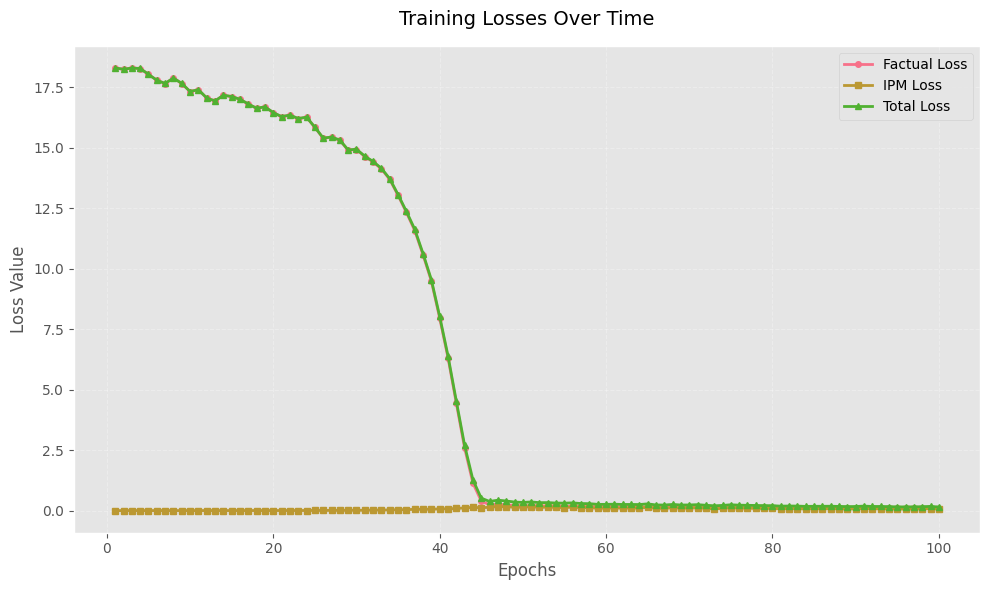

In [16]:
cutoff = 100
factual_losses_ = factual_losses[:cutoff]
ipm_losses_ = ipm_losses[:cutoff]
total_losses_ = total_losses[:cutoff]


plt.style.use('ggplot')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(10, 6))
epochs = range(1, len(factual_losses_) + 1)

ax.plot(epochs, factual_losses_, label='Factual Loss', linewidth=2, marker='o', markersize=4)
ax.plot(epochs, ipm_losses_, label='IPM Loss', linewidth=2, marker='s', markersize=4)
ax.plot(epochs, total_losses_, label='Total Loss', linewidth=2, marker='^', markersize=4)

# Customize plot
ax.set_xlabel('Epochs', fontsize=12)
ax.set_ylabel('Loss Value', fontsize=12)
ax.set_title('Training Losses Over Time', fontsize=14, pad=15)
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(fontsize=10, frameon=True)

ax.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
# plt.savefig('training_losses.png', dpi=300, bbox_inches='tight')

plt.show()

In [23]:
tar.eval()  # Set to evaluation mode
with torch.no_grad():
    X_test = torch.FloatTensor(X_te).to(device)
    ite, ate = calculate_treatment_effects(tar, X_test)
    
    print(f"Average Treatment Effect: {ate.item():.4f}")
    
    true_effect = mu_1_te - mu_0_te
    mse = torch.mean((ite.cpu() - true_effect)**2)
    print(f"MSE of treatment effect estimation: {mse.item():.4f}")
    

Average Treatment Effect: 2.1128
MSE of treatment effect estimation: 4.4113


/tmp/ipykernel_2964408/114584251.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse = torch.mean((ite.cpu() - true_effect)**2)


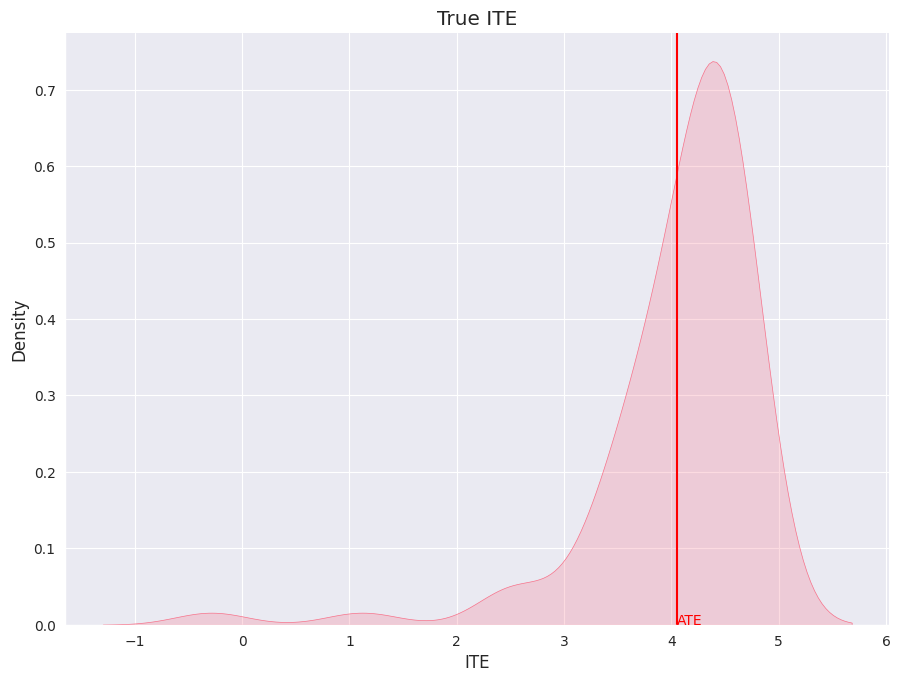

In [31]:
plot_ite_distribution(true_effect, title = "True ITE")

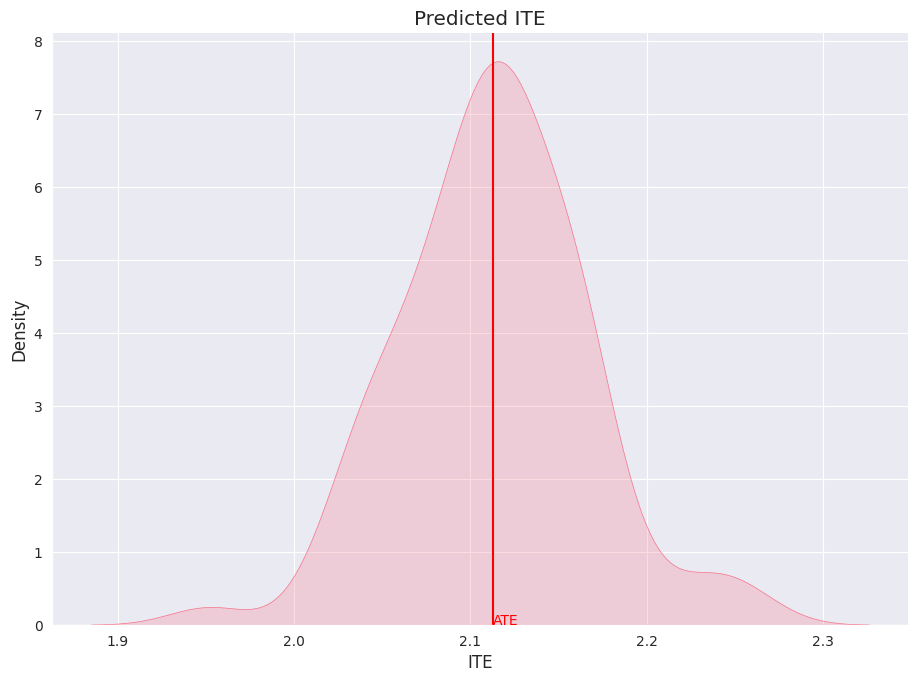

In [32]:
plot_ite_distribution(ite.cpu().numpy(), title = "Predicted ITE")